In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [25]:
df = pd.read_csv("apartments_for_rent_classified_10K.csv", delimiter=';', encoding="Windows-1252")

In [26]:
df = df[['amenities', 'bathrooms', 'bedrooms', 'has_photo', 'pets_allowed', 'price', 'square_feet', 'cityname', 'state']]
drop_null = ['bathrooms', 'bedrooms', 'cityname', 'state']
df = df.dropna(subset=drop_null)

In [27]:
df['amenities'] = df['amenities'].apply(lambda x: 0 if pd.isna(x) or str(x).strip() == '' else 1)
df['pets_allowed'] = df['pets_allowed'].apply(lambda x: 0 if pd.isna(x) or str(x).strip() == '' else 1)
df['has_photo'] = df['has_photo'].apply(lambda x: 1 if isinstance(x, str) and x.strip().lower() in ['yes', 'thumbnail'] else 0)

# Combine cityname and state into 'location'
df['location'] = df['cityname'].str.strip() + ", " + df['state'].str.strip()
# Calculate average price by location
avg_price = df.groupby('location')['price'].mean().reset_index(name='avg_price_location')
df = df.merge(avg_price, on='location', how='left')
df = df.drop(columns=['cityname', 'state'])

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9883 entries, 0 to 9882
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amenities           9883 non-null   int64  
 1   bathrooms           9883 non-null   float64
 2   bedrooms            9883 non-null   float64
 3   has_photo           9883 non-null   int64  
 4   pets_allowed        9883 non-null   int64  
 5   price               9883 non-null   int64  
 6   square_feet         9883 non-null   int64  
 7   location            9883 non-null   object 
 8   avg_price_location  9883 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 695.0+ KB


In [29]:
# Define features and scale them
features = ['amenities', 'bathrooms', 'bedrooms', 'has_photo', 'pets_allowed', 'square_feet', 'avg_price_location']
X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
# Build the autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 4

In [31]:
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the autoencoder with 50 iterations
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=64, shuffle=True, verbose=0)

# Get encoded (compressed) features
X_encoded = encoder.predict(X_scaled)

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


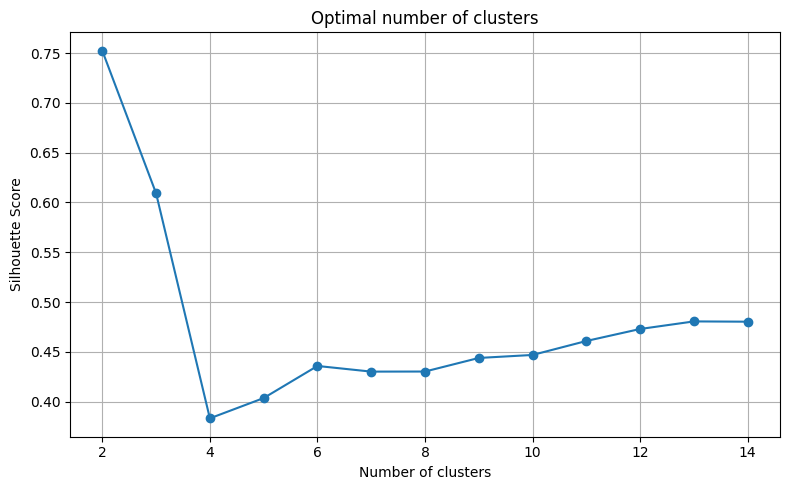

In [32]:
sil_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    score = silhouette_score(X_encoded, kmeans.fit_predict(X_encoded))
    sil_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 15), sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal number of clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
k = 3  # Best number of clusters based on silhouette or domain knowledge
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_encoded)
df['cluster'] = clusters

# Show average values per cluster
cluster_summary = df.groupby('cluster')[features + ['price']].mean()
print("\nCluster Feature Summary:\n")
print(cluster_summary)


Cluster Feature Summary:

         amenities  bathrooms  bedrooms  has_photo  pets_allowed  square_feet  \
cluster                                                                         
0         1.000000   1.308293  1.655502   1.000000      0.589952   877.620574   
1         0.000000   1.670774  2.128837   1.000000      0.869001  1214.326848   
2         0.113077   1.212692  1.509231   0.859231      0.050769   777.383077   

         avg_price_location        price  
cluster                                   
0               1438.385868  1405.302871  
1               1639.236946  1789.044099  
2               1450.260426  1343.280769  


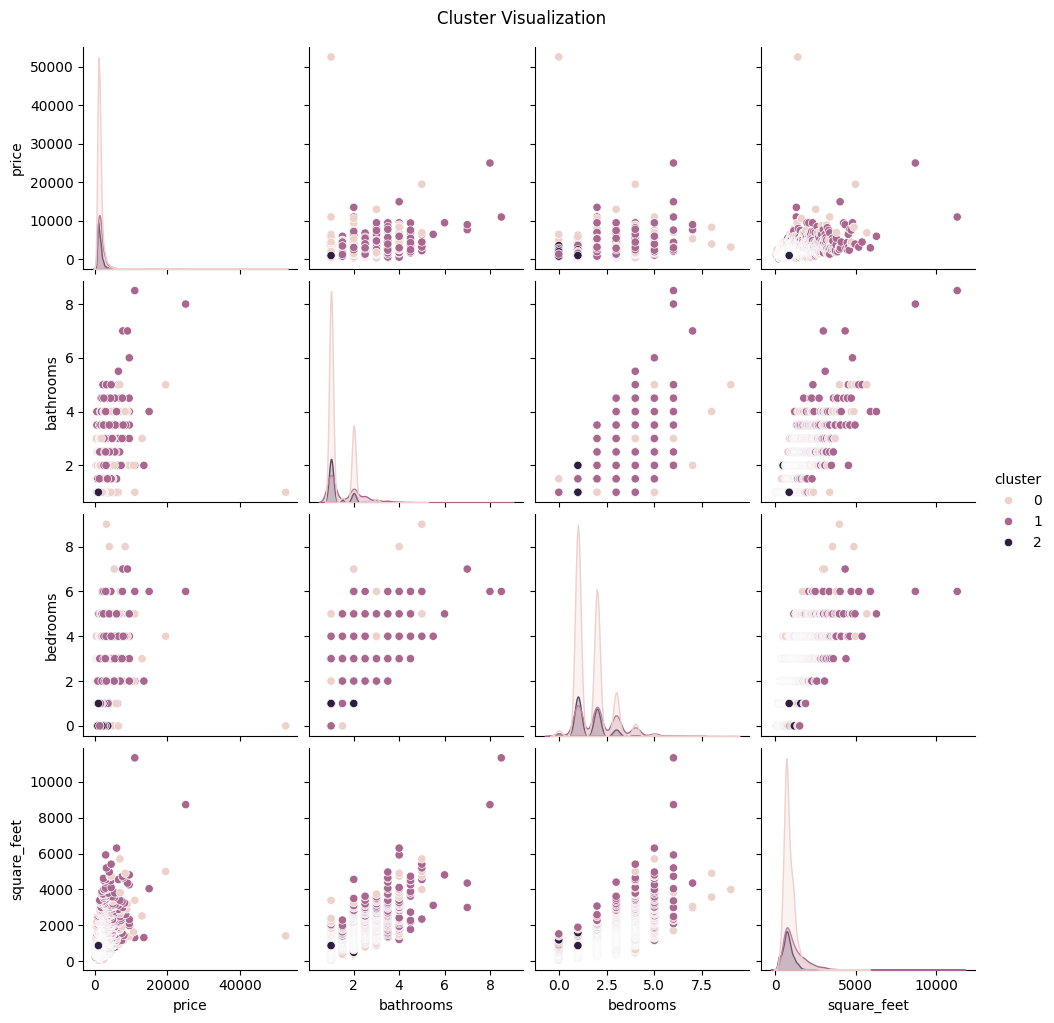

In [34]:
sns.pairplot(df, hue='cluster', vars=['price', 'bathrooms', 'bedrooms', 'square_feet'])
plt.suptitle("Cluster Visualization", y=1.02)
plt.show()


Detected Overpriced Listings: 1339
Detected Underpriced Listings: 1610


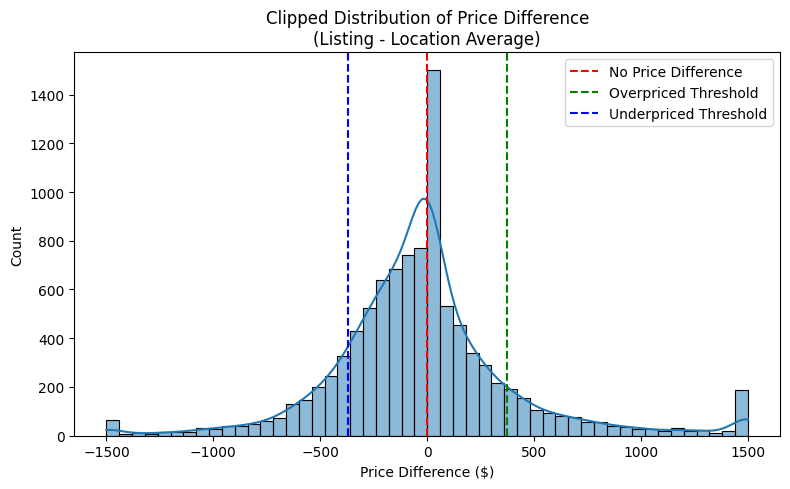


Top 5 Overpriced Listings:
      amenities  bathrooms  bedrooms  has_photo  pets_allowed  price  \
9874          1        5.0       4.0          1             1  19500   
9856          0        4.0       6.0          1             0  14950   
8485          0        2.0       2.0          1             0  13500   
9709          1        3.0       3.0          1             0  13000   
9880          0        8.0       6.0          1             0  25000   

      square_feet         location  avg_price_location  cluster    price_diff  \
9874         5000  Los Angeles, CA         3117.024242        0  16382.975758   
9856         4044  Los Angeles, CA         3117.024242        1  11832.975758   
8485         1325  Los Angeles, CA         3117.024242        1  10382.975758   
9709         2530  Los Angeles, CA         3117.024242        0   9882.975758   
9880         8716    Montecito, CA        16100.000000        1   8900.000000   

      overpriced  underpriced  
9874        True    

In [39]:
# ----------------------------
# Anomaly Detection Section
# ----------------------------

# Compute price difference
df['price_diff'] = df['price'] - df['avg_price_location']

# Define anomaly thresholds (25% deviation from average)
threshold = 0.25
df['overpriced'] = df['price_diff'] > threshold * df['avg_price_location']
df['underpriced'] = df['price_diff'] < -threshold * df['avg_price_location']

# Show number of anomalies
print("\nDetected Overpriced Listings:", df['overpriced'].sum())
print("Detected Underpriced Listings:", df['underpriced'].sum())

price_diff_clipped = df['price_diff'].clip(-1500, 1500)

plt.figure(figsize=(8, 5))
sns.histplot(price_diff_clipped, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--', label='No Price Difference')
plt.axvline(threshold * df['avg_price_location'].mean(), color='green', linestyle='--', label='Overpriced Threshold')
plt.axvline(-threshold * df['avg_price_location'].mean(), color='blue', linestyle='--', label='Underpriced Threshold')
plt.title("Clipped Distribution of Price Difference\n(Listing - Location Average)")
plt.xlabel("Price Difference ($)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# View top anomalies
print("\nTop 5 Overpriced Listings:")
print(df[df['overpriced']].sort_values(by='price_diff', ascending=False).head())

print("\nTop 5 Underpriced Listings:")
print(df[df['underpriced']].sort_values(by='price_diff').head())

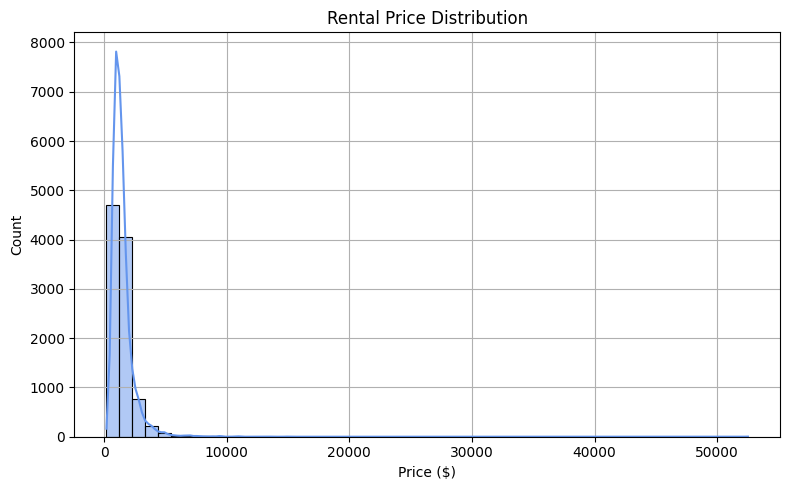

In [40]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=50, kde=True, color='cornflowerblue')
plt.title("Rental Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()